# WGAN-GP with R-GCN for the generation of small molecular graphs

**Author:** [akensert](https://github.com/akensert)<br>
**Date created:** 2021/06/30<br>
**Last modified:** 2021/06/30<br>
**Description:** Complete implementation of WGAN-GP with R-GCN to generate novel molecules.

## Introduction

In this tutorial, we implement a generative model for graphs and use it to generate
novel molecules.

Motivation: The [development of new drugs](https://en.wikipedia.org/wiki/Drug_development)
(molecules) can be extremely time-consuming and costly. The use of deep learning models
can alleviate the search for good candidate drugs, by predicting properties of known molecules
(e.g., solubility, toxicity, affinity to target protein, etc.). As the number of
possible molecules is astronomical, the space in which we search for/explore molecules is
just a fraction of the entire space. Therefore, it's arguably desirable to implement
generative models that can learn to generate novel molecules (which would otherwise have never been explored).

### References (implementation)

The implementation in this tutorial is based on/inspired by the
[MolGAN paper](https://arxiv.org/abs/1805.11973) and DeepChem's
[Basic MolGAN](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#basicmolganmod
el).

### Further reading (generative models)
Recent implementations of generative models for molecular graphs also include
[Mol-CycleGAN](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0404-1),
[GraphVAE](https://arxiv.org/abs/1802.03480) and
[JT-VAE](https://arxiv.org/abs/1802.04364). For more information on generative
adverserial networks, see [GAN](https://arxiv.org/abs/1406.2661),
[WGAN](https://arxiv.org/abs/1701.07875) and [WGAN-GP](https://arxiv.org/abs/1704.00028).

## Setup

### Install RDKit

[RDKit](https://www.rdkit.org/) is a collection of cheminformatics and machine-learning
software written in C++ and Python. In this tutorial, RDKit is used to conveniently and
efficiently transform
[SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) to
molecule objects, and then from those obtain sets of atoms and bonds.

SMILES expresses the structure of a given molecule in the form of an ASCII string.
The SMILES string is a compact encoding which, for smaller molecules, is relatively
human-readable. Encoding molecules as a string both alleviates and facilitates database
and/or web searching of a given molecule. RDKit uses algorithms to
accurately transform a given SMILES to a molecule object, which can then
be used to compute a great number of molecular properties/features.

Notice, RDKit is commonly installed via [Conda](https://www.rdkit.org/docs/Install.html).
However, thanks to
[rdkit_platform_wheels](https://github.com/kuelumbus/rdkit_platform_wheels), rdkit
can now (for the sake of this tutorial) be installed easily via pip, as follows:
```
pip -q install rdkit-pypi
```
And to allow easy visualization of a molecule objects, Pillow needs to be installed:
```
pip -q install Pillow
```

### Import packages

In [4]:
!pip install -q condacolab
import condacolab
condacolab.install()




✨🍰✨ Everything looks OK!


In [6]:
!conda install -c conda-forge rdkit -y

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [2]:
!pip -q install rdkit-pypi
#!pip -q install Pillow

In [7]:
from rdkit import Chem
mol = Chem.MolFromSmiles("CCO")
print("✅ Parsed molecule:", mol)


ModuleNotFoundError: No module named 'rdkit'

In [8]:
!wget -qO- https://micromamba.snakepit.net/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
!./bin/micromamba create -y -p /env -c conda-forge rdkit python=3.10


bin/micromamba
[+] 0.0s
[+] 0.1s
conda-forge/linux-64   1%
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64  11%
conda-forge/noarch    20%[+] 0.3s
conda-forge/linux-64  20%
conda-forge/noarch    40%[+] 0.4s
conda-forge/linux-64  28%
conda-forge/noarch    56%[+] 0.5s
conda-forge/linux-64  35%
conda-forge/noarch    71%[+] 0.6s
conda-forge/linux-64  38%
conda-forge/noarch    78%[+] 0.7s
conda-forge/linux-64  38%
conda-forge/noarch    78%[+] 0.8s
conda-forge/linux-64  38%
conda-forge/noarch    78%[+] 0.9s
conda-forge/linux-64  38%
conda-forge/noarch    78%[+] 1.0s
conda-forge/linux-64  38%
conda-forge/noarch    78%[+] 1.1s
conda-forge/linux-64  38%
conda-forge/noarch    79%[+] 1.2s
conda-forge/linux-64  38%
conda-forge/noarch    79%[+] 1.3s
conda-forge/linux-64  38%
conda-forge/noarch    79%[+] 1.4s
conda-forge/linux-64  38%
conda-forge/noarch    79%[+] 1.5s
conda-forge/linux-64  38%
conda-forge/noarch    79%[+] 1.6s
conda-forge/linux-64  38%
conda-forge/noarch    79%[+] 1.7s
conda-f

In [9]:
import sys
sys.path.append("/env/lib/python3.10/site-packages")


In [10]:
from rdkit import Chem
mol = Chem.MolFromSmiles("CCO")
print("✅ RDKit working:", mol)


✅ RDKit working: <rdkit.Chem.rdchem.Mol object at 0x7efe0e0669d0>


In [11]:
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import numpy as np
import tensorflow as tf
from tensorflow import keras

RDLogger.DisableLog("rdApp.*")

## Dataset

The dataset used in this tutorial is a
[quantum mechanics dataset](http://quantum-machine.org/datasets/) (QM9), obtained from
[MoleculeNet](http://moleculenet.ai/datasets-1). Although many feature and label columns
come with the dataset, we'll only focus on the
[SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
column. The QM9 dataset is a good first dataset to work with for generating
graphs, as the maximum number of heavy (non-hydrogen) atoms found in a molecule is only nine.

29856825/29856825 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
SMILES: Cn1cncc1O
Num heavy atoms: 7


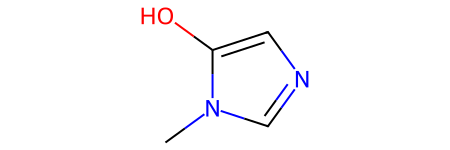

In [12]:
csv_path = tf.keras.utils.get_file(
    "qm9.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
)

data = []
with open(csv_path, "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# Let's look at a molecule of the dataset
smiles = data[1000]
print("SMILES:", smiles)
molecule = Chem.MolFromSmiles(smiles)
print("Num heavy atoms:", molecule.GetNumHeavyAtoms())
molecule

### Define helper functions
These helper functions will help convert SMILES to graphs and graphs to molecule objects.

**Representing a molecular graph**. Molecules can naturally be expressed as undirected
graphs `G = (V, E)`, where `V` is a set of vertices (atoms), and `E` a set of edges
(bonds). As for this implementation, each graph (molecule) will be represented as an
adjacency tensor `A`, which encodes existence/non-existence of atom-pairs with their
one-hot encoded bond types stretching an extra dimension, and a feature tensor `H`, which
for each atom, one-hot encodes its atom type. Notice, as hydrogen atoms can be inferred by
RDKit, hydrogen atoms are excluded from `A` and `H` for easier modeling.

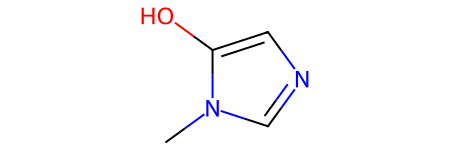

In [13]:
atom_mapping = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}

bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

NUM_ATOMS = 9  # Maximum number of atoms
ATOM_DIM = 4 + 1  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 64  # Size of the latent space


def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule


# Test helper functions
graph_to_molecule(smiles_to_graph(smiles))

### Generate training set

To save training time, we'll only use a tenth of the QM9 dataset.

In [14]:
adjacency_tensor, feature_tensor = [], []
for smiles in data[::10]:
    adjacency, features = smiles_to_graph(smiles)
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

adjacency_tensor.shape = (13389, 5, 9, 9)
feature_tensor.shape = (13389, 9, 5)


## Model

The idea is to implement a generator network and a discriminator network via WGAN-GP,
that will result in a generator network that can generate small novel molecules
(small graphs).

The generator network needs to be able to map (for each example in the batch) a vector `z`
to a 3-D adjacency tensor (`A`) and 2-D feature tensor (`H`). For this, `z` will first be
passed through a fully-connected network, for which the output will be further passed
through two separate fully-connected networks. Each of these two fully-connected
networks will then output (for each example in the batch) a tanh-activated vector
followed by a reshape and softmax to match that of a multi-dimensional adjacency/feature
tensor.

As the discriminator network will receives as input a graph (`A`, `H`) from either the
generator or from the training set, we'll need to implement graph convolutional layers,
which allows us to operate on graphs. This means that input to the discriminator network
will first pass through graph convolutional layers, then an average-pooling layer,
and finally a few fully-connected layers. The final output should be a scalar (for each
example in the batch) which indicates the "realness" of the associated input
(in this case a "fake" or "real" molecule).


### Graph generator

In [15]:

def GraphGenerator(
    dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape,
):
    z = keras.layers.Input(shape=(LATENT_DIM,))
    # Propagate through one or more densely connected layers
    x = z
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")


generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
generator.summary()

ValueError: Invalid dtype: <property object at 0x7efe0c60e3e0>

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Hyperparameters ---
LATENT_DIM   = 32
NUM_ATOMS    = 9
BOND_DIM     = 4
ATOM_DIM     = 5

# --- Generator ---
def GraphGenerator(
    dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape
):
    z = layers.Input(shape=(latent_dim,))
    x = z
    for units in dense_units:
        x = layers.Dense(units, activation="tanh")(x)
        x = layers.Dropout(dropout_rate)(x)

    # Continuous adjacency tensor [BOND_DIM, NUM_ATOMS, NUM_ATOMS]
    x_adjacency = layers.Dense(int(tf.reduce_prod(adjacency_shape)))(x)
    x_adjacency = layers.Reshape(adjacency_shape)(x_adjacency)

    # ✅ Wrap transpose symmetrization inside Lambda
    x_adjacency = layers.Lambda(
        lambda t: (t + tf.transpose(t, perm=[0, 1, 3, 2])) / 2
    )(x_adjacency)

    x_adjacency = layers.Softmax(axis=1)(x_adjacency)

    # Continuous feature tensor [NUM_ATOMS, ATOM_DIM]
    x_features = layers.Dense(int(tf.reduce_prod(feature_shape)))(x)
    x_features = layers.Reshape(feature_shape)(x_features)
    x_features = layers.Softmax(axis=2)(x_features)

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")


# --- Critic (Discriminator) ---
def GraphCritic(
    dense_units, dropout_rate, adjacency_shape, feature_shape
):
    adj_input = layers.Input(shape=adjacency_shape)
    feat_input = layers.Input(shape=feature_shape)

    # Flatten adjacency and feature tensors
    x_adj = layers.Flatten()(adj_input)
    x_feat = layers.Flatten()(feat_input)
    x = layers.Concatenate()([x_adj, x_feat])

    for units in dense_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    out = layers.Dense(1)(x)  # Wasserstein critic output

    return keras.Model(inputs=[adj_input, feat_input], outputs=out, name="Critic")


# --- Instantiate models ---
generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

critic = GraphCritic(
    dense_units=[512, 256, 128],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

# --- Summaries ---
print("✅ Generator Summary")
generator.summary()

print("\n✅ Critic Summary")
critic.summary()


✅ Generator Summary


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      4,224 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     33,024 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │    131,584 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 512)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 324)       │    166,212 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 4, 9, 9)   │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 45)        │     23,085 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4, 9, 9)   │          0 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 9, 5)      │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 4, 9, 9)   │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 9, 5)      │          0 │ reshape_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 358,129 (1.37 MB)

 Trainable params: 358,129 (1.37 MB)

 Non-trainable params: 0 (0.00 B)


✅ Critic Summary


Model: "Critic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 4, 9, 9)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 9, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 324)       │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 45)        │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 369)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │    189,440 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │        129 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,793 (1.35 MB)

 Trainable params: 353,793 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

### Graph discriminator


**Graph convolutional layer**. The
[relational graph convolutional layers](https://arxiv.org/abs/1703.06103) implements non-linearly transformed
neighborhood aggregations. We can define these layers as follows:

`H^{l+1} = σ(D^{-1} @ A @ H^{l+1} @ W^{l})`


Where `σ` denotes the non-linear transformation (commonly a ReLU activation), `A` the
adjacency tensor, `H^{l}` the feature tensor at the `l:th` layer, `D^{-1}` the inverse
diagonal degree tensor of `A`, and `W^{l}` the trainable weight tensor at the `l:th`
layer. Specifically, for each bond type (relation), the degree tensor expresses, in the
diagonal, the number of bonds attached to each atom. Notice, in this tutorial `D^{-1}` is
omitted, for two reasons: (1) it's not obvious how to apply this normalization on the
continuous adjacency tensors (generated by the generator), and (2) the performance of the
WGAN without normalization seems to work just fine. Furthermore, in contrast to the
[original paper](https://arxiv.org/abs/1703.06103), no self-loop is defined, as we don't
want to train the generator to predict "self-bonding".



In [18]:

class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


def GraphDiscriminator(
    gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape
):

    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # For each molecule, output a single scalar value expressing the
    # "realness" of the inputted molecule
    x_out = keras.layers.Dense(1, dtype="float32")(x)

    return keras.Model(inputs=[adjacency, features], outputs=x_out)


discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],
    dense_units=[512, 512],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 4, 9, 9)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 9, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │      2,560 │ input_layer_5[0]… │
│ (RelationalGraphCo… │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │     65,536 │ input_layer_5[0]… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │     65,536 │ input_layer_5[0]… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │     65,536 │ input_layer_5[0]… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ relational_graph… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │     66,048 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 512)       │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 512)       │    262,656 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 512)       │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │        513 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 528,385 (2.02 MB)

 Trainable params: 528,385 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

### WGAN-GP

In [19]:

class GraphWGAN(keras.Model):
    def __init__(
        self,
        generator,
        discriminator,
        discriminator_steps=1,
        generator_steps=1,
        gp_weight=10,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight
        self.latent_dim = self.generator.input_shape[-1]

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        super().compile(**kwargs)
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.metric_generator = keras.metrics.Mean(name="loss_gen")
        self.metric_discriminator = keras.metrics.Mean(name="loss_dis")

    def train_step(self, inputs):

        if isinstance(inputs[0], tuple):
            inputs = inputs[0]

        graph_real = inputs

        self.batch_size = tf.shape(inputs[0])[0]

        # Train the discriminator for one or more steps
        for _ in range(self.discriminator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_discriminator(graph_real, graph_generated)

            grads = tape.gradient(loss, self.discriminator.trainable_weights)
            self.optimizer_discriminator.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            self.metric_discriminator.update_state(loss)

        # Train the generator for one or more steps
        for _ in range(self.generator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_generator(graph_generated)

                grads = tape.gradient(loss, self.generator.trainable_weights)
                self.optimizer_generator.apply_gradients(
                    zip(grads, self.generator.trainable_weights)
                )
                self.metric_generator.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

    def _loss_discriminator(self, graph_real, graph_generated):
        logits_real = self.discriminator(graph_real, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        loss = tf.reduce_mean(logits_generated) - tf.reduce_mean(logits_real)
        loss_gp = self._gradient_penalty(graph_real, graph_generated)
        return loss + loss_gp * self.gp_weight

    def _loss_generator(self, graph_generated):
        logits_generated = self.discriminator(graph_generated, training=True)
        return -tf.reduce_mean(logits_generated)

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            logits = self.discriminator(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )


## Train the model

To save time (if run on a CPU), we'll only train the model for 10 epochs.

In [21]:
print("Adjacency shape:", adjacency_tensor.shape)
print("Feature shape:", feature_tensor.shape)


Adjacency shape: (13389, 5, 9, 9)
Feature shape: (13389, 9, 5)


In [22]:
LATENT_DIM   = 32
NUM_ATOMS    = 9
BOND_DIM     = 5      # 👈 changed from 4 → 5
ATOM_DIM     = 5


In [23]:
generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

critic = GraphCritic(
    dense_units=[512, 256, 128],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)


In [27]:
critic = GraphCritic(
    dense_units=[512, 256, 128],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
print("✅ New Critic input shape:", critic.input_shape)


✅ New Critic input shape: [(None, 5, 9, 9), (None, 9, 5)]


In [28]:
# ✅ MUST recreate WGAN after critic is rebuilt
wgan = GraphWGAN(generator, critic, discriminator_steps=1)

wgan.compile(
    optimizer_generator=keras.optimizers.Adam(5e-4),
    optimizer_discriminator=keras.optimizers.Adam(5e-4),
)


In [29]:
print("WGAN critic input shape:", wgan.discriminator.input_shape)

WGAN critic input shape: [(None, 5, 9, 9), (None, 9, 5)]


In [31]:
assert adjacency_tensor.shape[1:] == wgan.discriminator.input_shape[0][1:], "Adjacency mismatch!"
assert feature_tensor.shape[1:] == wgan.discriminator.input_shape[1][1:], "Feature mismatch!"
print("✅ All shapes match. Ready to train!")


✅ All shapes match. Ready to train!


In [32]:
wgan.fit([adjacency_tensor, feature_tensor], epochs=10, batch_size=16)

Epoch 1/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - loss: 0.0000e+00 - loss_dis: -26.8103 - loss_gen: -9.2012
Epoch 2/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0000e+00 - loss_dis: -5.7362 - loss_gen: -6.0252
Epoch 3/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0000e+00 - loss_dis: -5.0082 - loss_gen: -0.0828
Epoch 4/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0000e+00 - loss_dis: -5.2498 - loss_gen: -10.7313
Epoch 5/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0000e+00 - loss_dis: -5.5550 - loss_gen: -9.4205
Epoch 6/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0000e+00 - loss_dis: -5.1220 - loss_gen: -7.0705
Epoch 7/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0000e+00 - loss_dis: -4.7473 - loss_gen: -8.7837
Epoch 8/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0000e+00 - loss_dis: -4.4540 - loss_gen: -2.3979
Epoch 9/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0000e+00 - loss_dis: -5.0746 - loss_gen: -7.30

In [33]:
from sklearn.model_selection import train_test_split
import numpy as np

adj_train, adj_val, feat_train, feat_val = train_test_split(
    adjacency_tensor, feature_tensor, test_size=0.2, random_state=42
)

print("Train adjacency:", adj_train.shape)
print("Val adjacency:", adj_val.shape)


Train adjacency: (10711, 5, 9, 9)
Val adjacency: (2678, 5, 9, 9)


In [34]:
BATCH_SIZE = 16

train_ds = tf.data.Dataset.from_tensor_slices((adj_train, feat_train)).shuffle(1024).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((adj_val, feat_val)).batch(BATCH_SIZE)


In [36]:
real_adj, real_feat = inputs
self.batch_size = tf.shape(real_adj)[0]
graph_real = [real_adj, real_feat]


NameError: name 'inputs' is not defined

In [35]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_d_loss, train_g_loss = [], []

    # ---- Training Loop ----
    for real_adj, real_feat in train_ds:
        losses = wgan.train_on_batch([real_adj, real_feat])
        train_d_loss.append(losses[1])  # discriminator loss
        train_g_loss.append(losses[2])  # generator loss

    # ---- Validation Loop ----
    val_d_loss, val_g_loss = [], []
    for val_adj, val_feat in val_ds:
        # Generate fake graphs
        noise = tf.random.normal([val_adj.shape[0], LATENT_DIM])
        fake_adj, fake_feat = generator(noise, training=False)

        # Critic outputs
        real_logits = critic([val_adj, val_feat], training=False)
        fake_logits = critic([fake_adj, fake_feat], training=False)

        # WGAN losses
        d_loss_val = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)
        g_loss_val = -tf.reduce_mean(fake_logits)

        val_d_loss.append(d_loss_val.numpy())
        val_g_loss.append(g_loss_val.numpy())

    print(
        f"Train D: {np.mean(train_d_loss):.4f}, Train G: {np.mean(train_g_loss):.4f} | "
        f"Val D: {np.mean(val_d_loss):.4f}, Val G: {np.mean(val_g_loss):.4f}"
    )



Epoch 1/10


ValueError: Shapes must be equal rank, but are 4 and 3
	From merging shape 0 with other shapes. for '{{node Shape/packed}} = Pack[N=2, T=DT_FLOAT, axis=0](data, data_1)' with input shapes: [16,5,9,9], [16,9,5].

In [26]:
wgan = GraphWGAN(generator, discriminator, discriminator_steps=1)

wgan.compile(
    optimizer_generator=keras.optimizers.Adam(5e-4),
    optimizer_discriminator=keras.optimizers.Adam(5e-4),
)

wgan.fit([adjacency_tensor, feature_tensor], epochs=10, batch_size=16)

Epoch 1/10


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 4, 9, 9), found shape=(None, 5, 9, 9)

#CHAT CODE

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np

# ----------------------------
# Hyperparameters (match your data)
# ----------------------------
LATENT_DIM   = 32
NUM_ATOMS    = 9
BOND_DIM     = 5    # ✅ must match adjacency_tensor.shape[1]
ATOM_DIM     = 5    # ✅ must match feature_tensor.shape[2]
EPOCHS       = 10
BATCH_SIZE   = 16
LAMBDA_GP    = 10.0

# ----------------------------
# Generator
# ----------------------------
def GraphGenerator(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    z = layers.Input(shape=(latent_dim,))
    x = z
    for units in dense_units:
        x = layers.Dense(units, activation="tanh")(x)
        x = layers.Dropout(dropout_rate)(x)

    # Adjacency tensor
    x_adj = layers.Dense(int(tf.reduce_prod(adjacency_shape)))(x)
    x_adj = layers.Reshape(adjacency_shape)(x_adj)
    x_adj = layers.Lambda(lambda t: (t + tf.transpose(t, perm=[0, 1, 3, 2])) / 2)(x_adj)
    x_adj = layers.Softmax(axis=1)(x_adj)

    # Feature tensor
    x_feat = layers.Dense(int(tf.reduce_prod(feature_shape)))(x)
    x_feat = layers.Reshape(feature_shape)(x_feat)
    x_feat = layers.Softmax(axis=2)(x_feat)

    return keras.Model(inputs=z, outputs=[x_adj, x_feat], name="Generator")

# ----------------------------
# Critic (Discriminator)
# ----------------------------
def GraphCritic(dense_units, dropout_rate, adjacency_shape, feature_shape):
    adj_input = layers.Input(shape=adjacency_shape)
    feat_input = layers.Input(shape=feature_shape)
    x = layers.Concatenate()([layers.Flatten()(adj_input), layers.Flatten()(feat_input)])
    for units in dense_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(1)(x)
    return keras.Model(inputs=[adj_input, feat_input], outputs=out, name="Critic")

# ----------------------------
# Instantiate models
# ----------------------------
generator = GraphGenerator([128, 256, 512], 0.2, LATENT_DIM, (BOND_DIM, NUM_ATOMS, NUM_ATOMS), (NUM_ATOMS, ATOM_DIM))
critic = GraphCritic([512, 256, 128], 0.2, (BOND_DIM, NUM_ATOMS, NUM_ATOMS), (NUM_ATOMS, ATOM_DIM))

g_optimizer = keras.optimizers.Adam(5e-4)
d_optimizer = keras.optimizers.Adam(5e-4)

# ----------------------------
# Train/Validation split
# ----------------------------
adj_train, adj_val, feat_train, feat_val = train_test_split(
    adjacency_tensor, feature_tensor, test_size=0.2, random_state=42
)

train_ds = tf.data.Dataset.from_tensor_slices((adj_train, feat_train)).shuffle(1024).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((adj_val, feat_val)).batch(BATCH_SIZE)

# ----------------------------
# Gradient penalty (WGAN-GP)
# ----------------------------
def gradient_penalty(real, fake):
    alpha = tf.random.uniform([real[0].shape[0], 1, 1, 1], 0.0, 1.0)
    interpolated_adj = alpha * real[0] + (1 - alpha) * fake[0]
    interpolated_feat = alpha[:, 0, 0, 0:1] * real[1] + (1 - alpha[:, 0, 0, 0:1]) * fake[1]
    with tf.GradientTape() as gp_tape:
        gp_tape.watch([interpolated_adj, interpolated_feat])
        pred = critic([interpolated_adj, interpolated_feat], training=True)
    grads = gp_tape.gradient(pred, [interpolated_adj, interpolated_feat])
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grads[0])) + tf.reduce_sum(tf.square(grads[1])))
    return tf.square(slopes - 1.0)


def gradient_penalty(real, fake):
    real_adj, real_feat = real
    fake_adj, fake_feat = fake
    batch_size = tf.shape(real_adj)[0]

    # separate alpha for adjacency (4D) and feature (3D)
    alpha_adj = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    alpha_feat = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)

    interpolated_adj = alpha_adj * real_adj + (1 - alpha_adj) * fake_adj
    interpolated_feat = alpha_feat * real_feat + (1 - alpha_feat) * fake_feat

    with tf.GradientTape() as gp_tape:
        gp_tape.watch([interpolated_adj, interpolated_feat])
        pred = critic([interpolated_adj, interpolated_feat], training=True)

    grads = gp_tape.gradient(pred, [interpolated_adj, interpolated_feat])

    slopes_adj = tf.sqrt(tf.reduce_sum(tf.square(grads[0]), axis=[1, 2, 3]))
    slopes_feat = tf.sqrt(tf.reduce_sum(tf.square(grads[1]), axis=[1, 2]))

    slopes = (slopes_adj + slopes_feat) / 2.0
    return tf.reduce_mean(tf.square(slopes - 1.0))

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(EPOCHS):
    train_d_losses, train_g_losses = [], []
    for real_adj, real_feat in train_ds:
        batch_size = tf.shape(real_adj)[0]

        # ---- Train Critic ----
        noise = tf.random.normal([batch_size, LATENT_DIM])
        fake_adj, fake_feat = generator(noise, training=True)

        with tf.GradientTape() as d_tape:
            logits_real = critic([real_adj, real_feat], training=True)
            logits_fake = critic([fake_adj, fake_feat], training=True)
            d_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
            gp = gradient_penalty([real_adj, real_feat], [fake_adj, fake_feat])
            d_loss += LAMBDA_GP * gp

        d_grads = d_tape.gradient(d_loss, critic.trainable_variables)
        d_optimizer.apply_gradients(zip(d_grads, critic.trainable_variables))
        train_d_losses.append(d_loss.numpy())

        # ---- Train Generator ----
        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as g_tape:
            fake_adj, fake_feat = generator(noise, training=True)
            logits_fake = critic([fake_adj, fake_feat], training=True)
            g_loss = -tf.reduce_mean(logits_fake)
        g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))
        train_g_losses.append(g_loss.numpy())

    # ----------------------------
    # Validation losses
    # ----------------------------
    val_d_losses, val_g_losses = [], []
    for val_adj, val_feat in val_ds:
        noise = tf.random.normal([val_adj.shape[0], LATENT_DIM])
        fake_adj, fake_feat = generator(noise, training=False)
        val_logits_real = critic([val_adj, val_feat], training=False)
        val_logits_fake = critic([fake_adj, fake_feat], training=False)

        d_val = tf.reduce_mean(val_logits_fake) - tf.reduce_mean(val_logits_real)
        g_val = -tf.reduce_mean(val_logits_fake)
        val_d_losses.append(d_val.numpy())
        val_g_losses.append(g_val.numpy())

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train D: {np.mean(train_d_losses):.4f}, Train G: {np.mean(train_g_losses):.4f} | "
        f"Val D: {np.mean(val_d_losses):.4f}, Val G: {np.mean(val_g_losses):.4f}"
    )


Epoch 1/10 | Train D: -2.7225, Train G: 0.3014 | Val D: -1.4401, Val G: 3.3781
Epoch 2/10 | Train D: -1.6565, Train G: 0.4190 | Val D: -2.2318, Val G: 0.9904
Epoch 3/10 | Train D: -1.7539, Train G: -0.0864 | Val D: -1.7513, Val G: 0.5323
Epoch 4/10 | Train D: -1.6684, Train G: -0.1705 | Val D: -1.7450, Val G: -0.9527
Epoch 5/10 | Train D: -1.5357, Train G: -0.9348 | Val D: -1.5914, Val G: -1.3434
Epoch 6/10 | Train D: -1.5747, Train G: -0.4822 | Val D: -1.8393, Val G: 0.1612
Epoch 7/10 | Train D: -1.3954, Train G: -0.8700 | Val D: -1.6065, Val G: 0.5886
Epoch 8/10 | Train D: -1.5202, Train G: -0.5164 | Val D: -1.8218, Val G: 0.0433
Epoch 9/10 | Train D: -1.5706, Train G: -0.3720 | Val D: -1.7462, Val G: -1.4560
Epoch 10/10 | Train D: -1.4514, Train G: -0.5962 | Val D: -1.6662, Val G: -1.2056


In [ ]:
import matplotlib.pyplot as plt

EPOCHS = 30
patience = 5  # stop if Val G doesn't improve for 5 epochs
best_val_g = float("inf")
bad_epochs = 0

history = {"train_d": [], "train_g": [], "val_d": [], "val_g": [], "wasserstein": []}

for epoch in range(EPOCHS):
    train_d_losses, train_g_losses = [], []

    # ----------------------------
    # Train Loop
    # ----------------------------
    for real_adj, real_feat in train_ds:
        batch_size = tf.shape(real_adj)[0]

        # Train critic
        noise = tf.random.normal([batch_size, LATENT_DIM])
        fake_adj, fake_feat = generator(noise, training=True)

        with tf.GradientTape() as d_tape:
            logits_real = critic([real_adj, real_feat], training=True)
            logits_fake = critic([fake_adj, fake_feat], training=True)
            d_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
            gp = gradient_penalty([real_adj, real_feat], [fake_adj, fake_feat])
            d_loss += LAMBDA_GP * gp

        d_grads = d_tape.gradient(d_loss, critic.trainable_variables)
        d_optimizer.apply_gradients(zip(d_grads, critic.trainable_variables))
        train_d_losses.append(d_loss.numpy())

        # Train generator
        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as g_tape:
            fake_adj, fake_feat = generator(noise, training=True)
            logits_fake = critic([fake_adj, fake_feat], training=True)
            g_loss = -tf.reduce_mean(logits_fake)
        g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))
        train_g_losses.append(g_loss.numpy())

    # ----------------------------
    # Validation Loop
    # ----------------------------
    val_d_losses, val_g_losses, wasserstein_vals = [], [], []
    for val_adj, val_feat in val_ds:
        noise = tf.random.normal([val_adj.shape[0], LATENT_DIM])
        fake_adj, fake_feat = generator(noise, training=False)
        val_logits_real = critic([val_adj, val_feat], training=False)
        val_logits_fake = critic([fake_adj, fake_feat], training=False)

        d_val = tf.reduce_mean(val_logits_fake) - tf.reduce_mean(val_logits_real)
        g_val = -tf.reduce_mean(val_logits_fake)
        wasserstein = tf.reduce_mean(val_logits_real) - tf.reduce_mean(val_logits_fake)

        val_d_losses.append(d_val.numpy())
        val_g_losses.append(g_val.numpy())
        wasserstein_vals.append(wasserstein.numpy())

    # ----------------------------
    # Epoch summary
    # ----------------------------
    tD = np.mean(train_d_losses)
    tG = np.mean(train_g_losses)
    vD = np.mean(val_d_losses)
    vG = np.mean(val_g_losses)
    W  = np.mean(wasserstein_vals)

    history["train_d"].append(tD)
    history["train_g"].append(tG)
    history["val_d"].append(vD)
    history["val_g"].append(vG)
    history["wasserstein"].append(W)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train D: {tD:.4f}, Train G: {tG:.4f} | "
        f"Val D: {vD:.4f}, Val G: {vG:.4f} | W: {W:.4f}"
    )

    # ----------------------------
    # Early stopping check
    # ----------------------------
    if vG < best_val_g:
        best_val_g = vG
        bad_epochs = 0
        generator.save_weights("best_generator.h5")
        critic.save_weights("best_critic.h5")
    else:
        bad_epochs += 1
        print(f"⚠️ Validation G did not improve for {bad_epochs} epoch(s)")
        if bad_epochs >= patience:
            print("🛑 Early stopping triggered – possible overfitting.")
            break

# ----------------------------
# Plotting loss curves
# ----------------------------
plt.figure(figsize=(10,5))
plt.plot(history["train_g"], label="Train G")
plt.plot(history["val_g"], label="Val G")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.legend(); plt.title("Generator Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.show()

plt.figure(figsize=(10,5))
plt.plot(history["train_d"], label="Train D")
plt.plot(history["val_d"], label="Val D")
plt.legend(); plt.title("Critic Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.show()

plt.figure(figsize=(10,5))
plt.plot(history["wasserstein"], label="Wasserstein Distance")
plt.legend(); plt.title("Wasserstein Estimate (Higher = Better)")
plt.xlabel("Epoch"); plt.ylabel("W"); plt.show()


## Sample novel molecules with the generator

In [ ]:

def sample(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)
    # obtain one-hot encoded adjacency tensor
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    # Remove potential self-loops from adjacency
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    # obtain one-hot encoded feature tensor
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
    return [
        graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
        for i in range(batch_size)
    ]


molecules = sample(wgan.generator, batch_size=48)

MolsToGridImage(
    [m for m in molecules if m is not None][:25], molsPerRow=5, subImgSize=(150, 150)
)

## Concluding thoughts

**Inspecting the results**. Ten epochs of training seemed enough to generate some decent
looking molecules! Notice, in contrast to the
[MolGAN paper](https://arxiv.org/abs/1805.11973), the uniqueness of the generated
molecules in this tutorial seems really high, which is great!

**What we've learned, and prospects**. In this tutorial, a generative model for molecular
graphs was successfully implemented, which allowed us to generate novel molecules. In the
future, it would be interesting to implement generative models that can modify existing
molecules (for instance, to optimize solubility or protein-binding of an existing
molecule). For that however, a reconstruction loss would likely be needed, which is
tricky to implement as there's no easy and obvious way to compute similarity between two
molecular graphs.

Example available on HuggingFace

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-wgan%20graphs-black.svg)](https://huggingface.co/keras-io/wgan-molecular-graphs) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-wgan%20graphs-black.svg)](https://huggingface.co/spaces/keras-io/Generating-molecular-graphs-by-WGAN-GP) |